# Classification

### Import libraries and set the seed

In [1]:
import os, math, random, gc, pickle
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

import torch
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- Reproducibility --------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = Path("models_final");  MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = Path("results_final"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 5

# Text Preprocessing

In [2]:
def _safe_str(x) -> str:      # Return an empty string in case the value is None or Nan
    if x is None: 
        return ""
    if isinstance(x, float) and np.isnan(x): 
        return ""
    return str(x)

def compose_3cols(row, sep=" "):   # title + description + transcript
    parts = [
        _safe_str(row.get("title", "")).strip(),
        _safe_str(row.get("description", "")).strip(),
        _safe_str(row.get("transcript", "") or row.get("transcript_text", "")).strip(),
    ]
    parts = [p for p in parts if p]
    return sep.join(parts) if parts else ""

# Dataset Class

In [3]:
class BertClsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, target_col: str, max_len: int = 256):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer             # Autotokenzier in our case
        self.max_len = max_len           # fixed padded/truncated sequence length
        self.target_col = target_col

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]         # Get the row at idx index
        text = compose_3cols(row)        # Compose the final text by concatenating the 3 columns
        # Tokenize to fixed length, returning PyTorch tensors
        enc = self.tok(
            text,
            truncation=True,           # Cut longer texts to max_length
            padding="max_length",      # Pad shorter texts to max_length
            max_length=self.max_len,
            return_tensors="pt"      # Return torch tensors
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),          # LongTensor [L]
            "attention_mask": enc["attention_mask"].squeeze(0),         # LongTensor [L]
            "labels": torch.tensor(int(row[self.target_col]), dtype=torch.long)    # FloatTensor scalar (regression)
        }


# Prediction Model

In [4]:
class AttnPooler(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size)   # projects token vectors before scoring
        self.v = nn.Linear(hidden_size, 1, bias=False)  # score vector (v^T * tanh(W h_t))
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor):
        # hidden_states: (B,T,H) ; attention_mask: (B,T) with 1 for real tokens, 0 for padding
        H = torch.tanh(self.W(hidden_states))         # (B, T, H) nonlinearity before scoring
        logits = self.v(H).squeeze(-1)                # (B, T) raw attention scores per token
        logits = logits.masked_fill(attention_mask == 0, -1e9) # Mask out pads so they get ~0 probability after softmax
        a = torch.softmax(logits, dim=1)              # (B, T) normalized attention weights
        return torch.bmm(a.unsqueeze(1), hidden_states).squeeze(1)  # Weighted sum over time: (B, 1, T) @ (B, T, H) -> (B, 1, H) -> (B, H)

class BertClassifier(nn.Module):
    def __init__(self, num_classes: int = 5, bert_name: str = "bert-base-uncased", dropout: float = 0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_name)   # HF model (returns BaseModelOutput)
        H = self.bert.config.hidden_size      # hidden width (768 for base)
        self.pool = AttnPooler(H)                    # attention pooling over tokens
        self.head = nn.Sequential(                   # classification head - 5 classes
            nn.Dropout(dropout),
            nn.Linear(H, num_classes)
        )
        
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)  # Forward through BERT; we only need the last hidden states (B, T, H)
        last_hidden = out.last_hidden_state          # (B,T,H)
        pooled = self.pool(last_hidden, attention_mask) # Pool token representations using attention (masking pads) - (B, H)
        logits = self.head(pooled)                   # Map to classification targets (B,K)
        return logits

# Training Loop

In [5]:
@torch.no_grad()
def eval_classification(model, loader, num_classes: int = 5) -> Tuple[float, float, np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    probs_list, preds_list, tgts_list = [], [], []
    for batch in loader:
        ids  = batch["input_ids"].to(DEVICE)    # Move the token ids (B, T) to device
        mask = batch["attention_mask"].to(DEVICE)   # Move the attention mask (B, T) to device
        y    = batch["labels"].to(DEVICE)     # (B,)  integer class labels
        
        logits = model(ids, mask)    # Forward pass - predictions (B,num_classes)
        
        # Convert logits to probabilities and hard predictions
        probs  = torch.softmax(logits, dim=1)      # (B, C)
        pred   = torch.argmax(probs, dim=1)        # (B,)

        # Collect CPU copies to avoid holding GPU memory
        probs_list.append(probs.cpu().numpy())
        preds_list.append(pred.cpu().numpy())
        tgts_list.append(y.cpu().numpy())

    # Concatenate across batches; handle empty loader gracefully
    probs = np.vstack(probs_list) if probs_list else np.zeros((0, num_classes), dtype=float)
    preds = np.concatenate(preds_list) if preds_list else np.zeros((0,), dtype=int)
    tgts  = np.concatenate(tgts_list)  if tgts_list  else np.zeros((0,), dtype=int)

    # Compute metrics (avoid errors on empty sets)
    acc = float(accuracy_score(tgts, preds)) if tgts.size else 0.0
    f1  = float(f1_score(tgts, preds, average="macro", zero_division=0)) if tgts.size else 0.0
    
    return acc, f1, probs, preds, tgts

In [6]:
# -------------------- Train loop (CE, warmup, early-stop) --------------------
def train_bert_classification(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    target_col: str,               # "view_range_enc_ind" or "view_range_enc_dep"
    num_classes: int = 5,
    max_len: int = 256,
    epochs: int = 8,
    batch_size: int = 16,
    lr: float = 2e-5,
    weight_decay: float = 0.01,
    warmup_ratio: float = 0.1,
    dropout: float = 0.1,
    early_stop_patience: int = 10,
    seed: int = 42,
):
    set_seed(seed)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True) # HuggingFace tokenizer 

    # Wrap DataFrames with HF-style Dataset that yields input_ids/attention_mask/labels
    ds_tr = BertClsDataset(train_df, tokenizer, target_col=target_col, max_len=max_len)
    ds_va = BertClsDataset(val_df,   tokenizer, target_col=target_col, max_len=max_len)

    # Deterministic shuffling for train loader
    g = torch.Generator(device="cpu").manual_seed(int(seed))
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  generator=g, num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, generator=g, num_workers=0)

    # BERT backbone + classifier head
    model = BertClassifier(num_classes=num_classes, bert_name="bert-base-uncased", dropout=dropout).to(DEVICE)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Linear warmup/decay schedule (step each optimizer step)
    total_steps  = epochs * max(1, len(dl_tr))         # total optimizer steps over all epochs
    warmup_steps = int(warmup_ratio * total_steps)     # warmup steps up front
    scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    # Early-stopping trackers (maximize val F1)
    best_val_f1 = -float("inf") 
    best_state = None 
    bad = 0

    for ep in range(1, epochs + 1):
        model.train()        # Model in train mode
        for batch in dl_tr:
            # Move batch to device
            ids  = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y    = batch["labels"].to(DEVICE)     # (B,) integer class ids

            # Forward -> logits (B, num_classes)
            logits = model(ids, mask)
            loss = criterion(logits, y)

            # Backprop + update
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # stabilize training
            optimizer.step()
            scheduler.step()          # update LR per step

        # Epoch-level metrics on train/val (no grad)
        tr_acc, tr_f1, _, _, _ = eval_classification(model, dl_tr, num_classes=num_classes)
        va_acc, va_f1, _, _, _ = eval_classification(model, dl_va, num_classes=num_classes)
        print(f"Epoch {ep:02d} | Train Acc {tr_acc:.4f}  F1 {tr_f1:.4f} | Val Acc {va_acc:.4f}  F1 {va_f1:.4f}")

        # Early stopping on validation macro-F1 with tiny tolerance
        if va_f1 > best_val_f1 + 1e-12:
            best_val_f1 = va_f1
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}  # Save a CPU copy of weights to restore later
            bad = 0
        else:
            bad += 1
            if bad >= early_stop_patience:
                print("Early stopping.")
                break

    # Restore best checkpoint if we found one
    if best_state is not None:
        model.load_state_dict(best_state)

    # Final metrics (computed on best weights)
    tr_acc, tr_f1, _, _, _ = eval_classification(model, dl_tr, num_classes=num_classes)
    va_acc, va_f1, _, _, _ = eval_classification(model, dl_va, num_classes=num_classes)
    metrics = {"train_acc": tr_acc, "train_f1": tr_f1, "val_acc": va_acc, "val_f1": va_f1}
    return model, tokenizer, metrics

In [7]:
def plot_confusion_and_report(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    cm = confusion_matrix(y_true, y_pred)     # raw counts (C x C)
    plt.figure(figsize=(5.5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)    # heatmap of confusion matrxi
    plt.xlabel("Predicted") 
    plt.ylabel("True") 
    plt.title(title)
    plt.tight_layout()
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

def plot_roc_multiclass(y_true: np.ndarray, probs: np.ndarray, num_classes: int, title: str):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes))) # one-vs-rest targets (N, C)
    # Handle rare case when a class is missing in val
    present = y_true_bin.sum(axis=0) > 0
    if present.sum() < 1:    # no positive labels at all
        print("ROC skipped: not enough classes present in validation.")
        return

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        if not present[i]:        # skip absent class
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i]) # Per-class ROC vs rest using the corresponding probability column
        roc_auc[i] = auc(fpr[i], tpr[i])         # scalar AUC for class i

    # Micro-average ROC: treat every (sample, class) as a binary decision
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin[:, present].ravel(), probs[:, present].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average ROC: average the TPRs interpolated over a union of FPR points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes) if present[i]]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        if present[i]:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])        # interpolate each class TPR
    mean_tpr /= present.sum()
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot curves
    plt.figure(figsize=(6, 5))
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.3f})", linewidth=2)
    plt.plot(all_fpr, mean_tpr, label=f"macro-average (AUC = {roc_auc['macro']:.3f})", linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--", color="gray")     # baseline
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right"); plt.tight_layout()

# Optuna for Hyperparameter Tuning

In [8]:
import optuna

def tune_bert_classification_optuna(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    tag: str,                          # "ind" or "dep"
    target_col: str,                   # "view_range_enc_ind" / "view_range_enc_dep"
    num_classes: int = 5,
    n_trials: int = 15,
    seed: int = 42,
    max_len: int = 256,                # keep fixed
    epochs_fixed: int = 30,
):

    set_seed(seed)
    sampler = optuna.samplers.TPESampler(seed=seed)   # Reproducibility
    study = optuna.create_study(direction="maximize", sampler=sampler)  # maximize val F1

    def objective(trial: optuna.trial.Trial):
        params = dict(
            lr            = trial.suggest_float("lr", 1e-5, 5e-5, log=True), # Suggest any float between the given range  sampled log uniformly
            weight_decay  = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True), # Suggest any float between the given range  sampled log uniformly
            warmup_ratio  = trial.suggest_float("warmup_ratio", 0.0, 0.2),  # Suggest any float between the given range
            dropout       = trial.suggest_float("dropout", 0.05, 0.4),    # Suggest any float between the given range
        )

         # Train the model and get the model, tokens and metrics
        model, tok, mets = train_bert_classification(
            train_df=train_df, val_df=val_df,
            target_col=target_col, num_classes=num_classes,
            max_len=max_len, epochs=epochs_fixed,
            lr=params["lr"], weight_decay=params["weight_decay"], warmup_ratio=params["warmup_ratio"],
            dropout=params["dropout"], early_stop_patience=10, seed=seed,
        )
        
        val_f1 = float(mets["val_f1"]) # Retrieve the validation F1
        
        # cleanup GPU between trials
        del model, tok
        if torch.cuda.is_available():
            torch.cuda.empty_cache()    # Free CUDA cache
        gc.collect()
        return val_f1

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    print("Best val F1:", study.best_value)
    print("Best params:", study.best_params)

    # retrain once with best params and return + save artifacts + plots
    p = study.best_params
    best_model, best_tok, best_metrics = train_bert_classification(
        train_df=train_df, val_df=val_df, target_col=target_col,
        num_classes=num_classes, max_len=max_len, epochs=epochs_fixed,
        lr=p["lr"], weight_decay=p["weight_decay"], warmup_ratio=p["warmup_ratio"],
        dropout=p["dropout"], early_stop_patience=10, seed=seed,
    )

    # VAL predictions (for fusion) + plots
    g = torch.Generator(device="cpu").manual_seed(int(seed))
    ds_va = BertClsDataset(val_df, best_tok, target_col=target_col, max_len=max_len)
    dl_va = DataLoader(ds_va, batch_size=16, shuffle=False, generator=g, num_workers=0)
    va_acc, va_f1, va_probs, va_preds, va_tgts = eval_classification(best_model, dl_va, num_classes=num_classes)
    video_ids = val_df["video_id"].to_numpy()

    # Save artifacts
    pt_path  = MODEL_DIR / f"text_cls_{tag}.pt"
    pkl_path = MODEL_DIR / f"text_cls_{tag}.pkl"
    csv_path = RESULTS_DIR / f"text_cls_val_{tag}.csv"

    torch.save(best_model.state_dict(), pt_path)

    bundle = {
        "model_class": "BertClassifier",
        "encoder_model": "bert-base-uncased",
        "pooling": "attn",
        "head": "linear",
        "num_classes": int(num_classes),
        "state_dict": {k: v.detach().cpu().numpy() for k, v in best_model.state_dict().items()},
        "tokenizer_name": "bert-base-uncased",
        "hyperparams": {
            **p,
            "target_col": target_col,
            "max_len": max_len,
            "seed": seed,
        },
        "metrics": {k: float(v) for k, v in best_metrics.items()},
        "version": {"torch": torch.__version__},
    }
    with open(pkl_path, "wb") as f:
        pickle.dump(bundle, f)

    # CSV — validation predictions (+ per-class probs)
    out = pd.DataFrame({
        "video_id": video_ids,
        "y_true":   va_tgts.astype(int),
        "y_pred":   va_preds.astype(int),
    })
    for c in range(num_classes):
        out[f"prob_c{c}"] = va_probs[:, c].astype(np.float32)
    out.to_csv(csv_path, index=False)

    # Plots: Confusion Matrix + ROC-AUC (micro & macro)
    plot_confusion_and_report(va_tgts, va_preds, title=f"BERT Text Classification — Confusion Matrix ({tag})")
    plot_roc_multiclass(va_tgts, va_probs, num_classes=num_classes,
                        title=f"BERT Text Classification — ROC (micro/macro) ({tag})")

    print(f"[Saved]\n  {pt_path}\n  {pkl_path}\n  {csv_path}")
    print(f"[VAL] Acc={va_acc:.4f} | Macro-F1={va_f1:.4f}")
    return study, best_model, best_tok, best_metrics, study.best_params

# Person-Independent Split

[I 2025-08-16 23:27:42,084] A new study created in memory with name: no-name-de6a6102-c51a-41b1-833e-224979ef1092


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 01 | Train Acc 0.1533  F1 0.1285 | Val Acc 0.2000  F1 0.1745
Epoch 02 | Train Acc 0.2933  F1 0.2252 | Val Acc 0.2200  F1 0.2088
Epoch 03 | Train Acc 0.4400  F1 0.4235 | Val Acc 0.2200  F1 0.2201
Epoch 04 | Train Acc 0.4567  F1 0.3993 | Val Acc 0.2000  F1 0.1582
Epoch 05 | Train Acc 0.5167  F1 0.4811 | Val Acc 0.2400  F1 0.1989
Epoch 06 | Train Acc 0.7567  F1 0.7542 | Val Acc 0.3000  F1 0.2950
Epoch 07 | Train Acc 0.8367  F1 0.8316 | Val Acc 0.2800  F1 0.2867
Epoch 08 | Train Acc 0.9033  F1 0.9022 | Val Acc 0.3000  F1 0.2993
Epoch 09 | Train Acc 0.9367  F1 0.9356 | Val Acc 0.3400  F1 0.3491
Epoch 10 | Train Acc 0.9467  F1 0.9463 | Val Acc 0.2000  F1 0.1753
Epoch 11 | Train Acc 0.9800  F1 0.9796 | Val Acc 0.3000  F1 0.3092
Epoch 12 | Train Acc 0.9867  F1 0.9864 | Val Acc 0.3600  F1 0.3452
Epoch 13 | Train Acc 0.9867  F1 0.9864 | Val Acc 0.2600  F1 0.2389
Epoch 14 | Train Acc 0.9867  F1 0.9864 | Val Acc 0.3000  F1 0.3070
Epoch 15 | Train Acc 0.9867  F1 0.9864 | Val Acc 0.2800  F1 0.

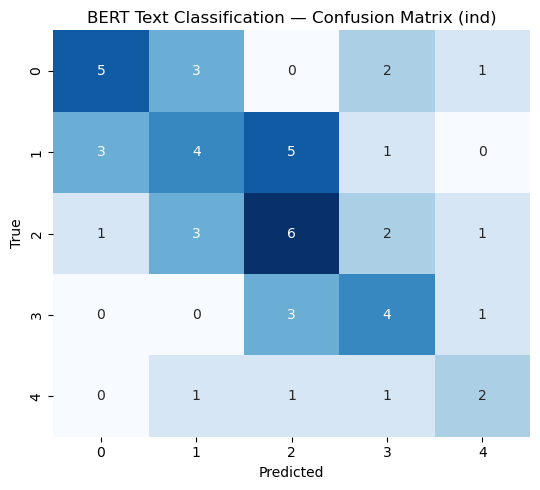

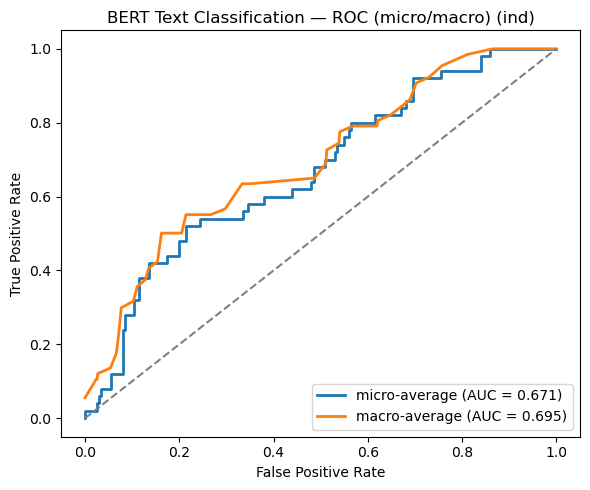

In [9]:
df = pd.read_csv("FinalDataset.csv")

# Person-Independent
train_ids_ind = set(os.listdir("Person-Independent_Split/train"))
val_ids_ind   = set(os.listdir("Person-Independent_Split/val"))
train_df_ind  = df[df.video_id.isin(train_ids_ind)].reset_index(drop=True)
val_df_ind    = df[df.video_id.isin(val_ids_ind)].reset_index(drop=True)
study_ind, best_model_ind, best_tok_ind, best_mets_ind, best_params_ind = tune_bert_classification_optuna(
    train_df_ind, val_df_ind, tag="ind",
    target_col="view_range_enc_ind", num_classes=5,
    n_trials=15, seed=42, max_len=256, epochs_fixed=30
)

In [10]:
print("Person-Independent Split:")
print(f"Best Val Acc:" , {best_mets_ind['val_acc']})
print(f"Best Val F1:", {best_mets_ind['val_f1']})

Person-Independent Split:
Best Val Acc: {0.42}
Best Val F1: {0.4212698412698413}


# Person-Dependent Split

[I 2025-08-17 00:35:00,529] A new study created in memory with name: no-name-90964e7e-0590-4aae-95d8-401d618e5af7


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 01 | Train Acc 0.1906  F1 0.1633 | Val Acc 0.0980  F1 0.0972
Epoch 02 | Train Acc 0.3177  F1 0.2816 | Val Acc 0.2157  F1 0.1767
Epoch 03 | Train Acc 0.4448  F1 0.4221 | Val Acc 0.2157  F1 0.1335
Epoch 04 | Train Acc 0.5117  F1 0.4942 | Val Acc 0.3529  F1 0.2752
Epoch 05 | Train Acc 0.5886  F1 0.5865 | Val Acc 0.3333  F1 0.2716
Epoch 06 | Train Acc 0.7291  F1 0.7295 | Val Acc 0.4118  F1 0.3681
Epoch 07 | Train Acc 0.8428  F1 0.8430 | Val Acc 0.4314  F1 0.3989
Epoch 08 | Train Acc 0.9365  F1 0.9362 | Val Acc 0.4314  F1 0.3874
Epoch 09 | Train Acc 0.9732  F1 0.9732 | Val Acc 0.4902  F1 0.4671
Epoch 10 | Train Acc 0.9799  F1 0.9799 | Val Acc 0.5098  F1 0.4880
Epoch 11 | Train Acc 0.9799  F1 0.9799 | Val Acc 0.4314  F1 0.4144
Epoch 12 | Train Acc 0.9866  F1 0.9867 | Val Acc 0.5294  F1 0.4919
Epoch 13 | Train Acc 0.9900  F1 0.9900 | Val Acc 0.4902  F1 0.4771
Epoch 14 | Train Acc 0.9900  F1 0.9900 | Val Acc 0.5686  F1 0.5707
Epoch 15 | Train Acc 0.9866  F1 0.9867 | Val Acc 0.5686  F1 0.

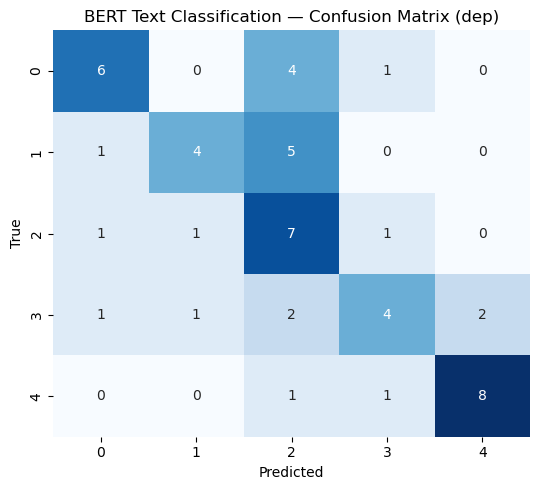

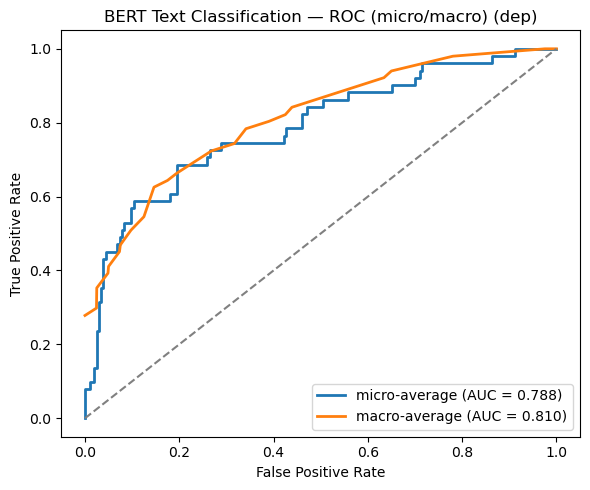

In [11]:
# Person-Dependent
train_ids_dep = set(os.listdir("Person-Dependent_Split/train"))
val_ids_dep   = set(os.listdir("Person-Dependent_Split/val"))
train_df_dep  = df[df.video_id.isin(train_ids_dep)].reset_index(drop=True)
val_df_dep    = df[df.video_id.isin(val_ids_dep)].reset_index(drop=True)
study_dep, best_model_dep, best_tok_dep, best_mets_dep, best_params_dep = tune_bert_classification_optuna(
    train_df_dep, val_df_dep, tag="dep",
    target_col="view_range_enc_dep", num_classes=5,
    n_trials=15, seed=42, max_len=256, epochs_fixed=30
)

In [12]:
print("Person-Independent Split:")
print(f"Best Val Acc:" , {best_mets_dep['val_acc']})
print(f"Best Val F1:", {best_mets_dep['val_f1']})

Person-Independent Split:
Best Val Acc: {0.5686274509803921}
Best Val F1: {0.5706693711967545}


# Test Predictions

In [13]:
# ==================== Train on train+val (with internal val) and Test — Text Classification ====================
import os, copy, json, pickle, random, gc
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

SEED       = 42
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH   = "FinalDataset.csv"   # <-- your single master CSV
BASE_PI    = "Person-Independent_Split"
BASE_PD    = "Person-Dependent_Split"
MODEL_DIR  = Path("models_final");  MODEL_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR= Path("results_final"); RESULTS_DIR.mkdir(exist_ok=True, parents=True)

LABEL_COL_MAP = {
    "ind": "view_range_enc_ind",
    "dep": "view_range_enc_dep",
}
NUM_CLASSES = 5

set_seed(SEED)

def read_ids_from_dir(dir_path: str):
    assert os.path.isdir(dir_path), f"Missing directory: {dir_path}"
    return set(os.path.splitext(fn)[0] for fn in os.listdir(dir_path))

# Build trainval_df and test_df using your *original* PI/PD id lists.
def get_dfs_for_split(split_tag: str):
    df = pd.read_csv(CSV_PATH)
    base = BASE_PI if split_tag == "ind" else BASE_PD

    train_ids = read_ids_from_dir(os.path.join(base, "train"))
    val_ids   = read_ids_from_dir(os.path.join(base, "val"))
    test_ids  = read_ids_from_dir(os.path.join(base, "test"))

    trainval_ids = train_ids | val_ids
    trainval_df  = df[df.video_id.isin(trainval_ids)].reset_index(drop=True)    # train + val
    test_df      = df[df.video_id.isin(test_ids)].reset_index(drop=True)        # test

    label_col = LABEL_COL_MAP[split_tag]
    need = {"video_id","channel_id",label_col}
    assert need.issubset(set(trainval_df.columns)) and need.issubset(set(test_df.columns)), \
        f"Missing columns: {need}"
    return trainval_df, test_df

def build_internal_val_from_labels(trainval_df: pd.DataFrame, split_tag: str, val_rel=0.15, seed=SEED):
    """
    ONE internal validation split from train+val using the PRE-ENCODED class labels.
    - PI: StratifiedGroupKFold(stratify=LABEL_COL_MAP['ind'], groups=channel_id)
    - PD: StratifiedKFold(stratify=LABEL_COL_MAP['dep'])
    """
    label_col = LABEL_COL_MAP[split_tag]
    y = trainval_df[label_col].astype(int).to_numpy()  
    idx = np.arange(len(trainval_df))
    n_splits = max(2, int(round(1.0 / val_rel)))

    if split_tag == "ind":
        groups = trainval_df["channel_id"].to_numpy()
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed) # no channel overlap for ind
        tr_idx, va_idx = next(cv.split(idx, y, groups=groups))
    else:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)  # for dep
        tr_idx, va_idx = next(cv.split(idx.reshape(-1,1), y))
    return tr_idx, va_idx

# Load best hyperparams + weights 
def load_best_text_classifier(split_tag: str):
    pkl_path = MODEL_DIR / f"text_cls_{split_tag}.pkl"
    pt_path  = MODEL_DIR / f"text_cls_{split_tag}.pt"
    assert pkl_path.exists() and pt_path.exists(), f"Missing artifacts for split={split_tag}"

    with open(pkl_path, "rb") as f:
        bundle = pickle.load(f)
    best_hp = dict(bundle.get("hyperparams", {}))

    state_dict = torch.load(pt_path, map_location=DEVICE)
    return best_hp, state_dict

#  Train (fine-tune) on train+val with internal val 
def train_from_tv_and_test_cls(split_tag: str, epochs=30, early_stop_patience=10, batch_size=16):
    print(f"\n===== [{split_tag}] Train+Val -> Test (Text Classification) =====")
    best_hp, init_state = load_best_text_classifier(split_tag)  # Load the best model
    print("Best hyper-params (loaded):", best_hp)

    trainval_df, test_df = get_dfs_for_split(split_tag)
    label_col = LABEL_COL_MAP[split_tag]
    print(f"train+val: {len(trainval_df)} | test: {len(test_df)}")

    tr_idx, va_idx = build_internal_val_from_labels(trainval_df, split_tag=split_tag, val_rel=0.15, seed=best_hp.get("seed", SEED))
    tr_in = trainval_df.iloc[tr_idx].reset_index(drop=True)
    va_in = trainval_df.iloc[va_idx].reset_index(drop=True)
    print(f"internal train: {len(tr_in)} | internal val: {len(va_in)}")

    # tokenizer + datasets
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
    max_len = int(best_hp.get("max_len", 256))
    ds_tr = BertClsDataset(tr_in, tokenizer, target_col=label_col, max_len=max_len)
    ds_va = BertClsDataset(va_in, tokenizer, target_col=label_col, max_len=max_len)
    ds_te = BertClsDataset(test_df, tokenizer, target_col=label_col, max_len=max_len)

    # Dataloaders
    g = torch.Generator(device="cpu").manual_seed(int(best_hp.get("seed", SEED)))
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  generator=g, num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, generator=g, num_workers=0)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, generator=g, num_workers=0)

    # model (+load previous best weights as init)
    model = BertClassifier(bert_name="bert-base-uncased",
                           dropout=float(best_hp.get("dropout", 0.1)),
                           num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(init_state)

    criterion = nn.CrossEntropyLoss()   # Loss
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=float(best_hp["lr"]),
                                  weight_decay=float(best_hp["weight_decay"]))   # Optimizer - Get the best params
    total_steps  = epochs * max(1, len(dl_tr))
    warmup_steps = int(float(best_hp["warmup_ratio"]) * total_steps)
    scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)  # LR Scheduler

    # fine-tune with early stop on val F1
    best_f1 = -1.0
    best_state = copy.deepcopy(model.state_dict())
    bad = 0
    for ep in range(1, epochs+1):
        model.train()
        for batch in dl_tr:
            ids  = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            y    = batch["labels"].to(DEVICE)
            logits = model(ids, mask)     # forward pass
            loss = criterion(logits, y)   # Calculate loss
            optimizer.zero_grad()     # Reset grads
            loss.backward()         # Backpropagation
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()

        tr_acc, tr_f1, _, _, _ = eval_classification(model, dl_tr, num_classes=NUM_CLASSES)   # Evalute on train set
        va_acc, va_f1, _, _, _ = eval_classification(model, dl_va, num_classes=NUM_CLASSES)   # Evaluate on val
        print(f"Epoch {ep:02d} | Train Acc {tr_acc:.4f} F1 {tr_f1:.4f} || Val Acc {va_acc:.4f} F1 {va_f1:.4f}")

        if va_f1 > best_f1 + 1e-12:
            best_f1 = va_f1
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= early_stop_patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_state)

    #  TEST 
    te_acc, te_f1, te_prob, te_pred, te_true = eval_classification(  # Evaluate on the test set
        model, dl_te, num_classes=NUM_CLASSES
    )
    print(f"[{split_tag}] TEST — Acc={te_acc:.4f} | Macro-F1={te_f1:.4f}")

    # Save deployment candidate (train+val weights)
    final_pt  = MODEL_DIR / f"text_cls_final_{split_tag}.pt"
    final_pkl = MODEL_DIR / f"text_cls_final_{split_tag}.pkl"
    torch.save(model.state_dict(), final_pt)

    bundle = {
        "model_class": "BertClassifier",
        "encoder_model": "bert-base-uncased",
        "pooling": "attn",
        "head": "linear",
        "num_classes": NUM_CLASSES,
        "state_dict": {k: v.detach().cpu().numpy() for k, v in model.state_dict().items()},
        "tokenizer_name": "bert-base-uncased",
        "hyperparams": {
            "max_len": max_len,
            "lr": float(best_hp["lr"]),
            "weight_decay": float(best_hp["weight_decay"]),
            "warmup_ratio": float(best_hp["warmup_ratio"]),
            "dropout": float(best_hp["dropout"]),
            "seed": int(best_hp.get("seed", SEED)),
        },
        "metrics": {
            "internal_val_best_f1": float(best_f1),
            "test_acc": float(te_acc),
            "test_f1":  float(te_f1),
        },
        "version": {"torch": torch.__version__},
    }
    with open(final_pkl, "wb") as f:
        pickle.dump(bundle, f)
    print(f"[Saved deployment candidate]\n  {final_pt}\n  {final_pkl}")

    # Save CSV (test predictions)
    out = pd.DataFrame({
        "video_id": test_df["video_id"].to_numpy(),
        "y_true":   te_true.astype(int),
        "y_pred":   te_pred.astype(int),
    })
    for c in range(NUM_CLASSES):
        out[f"prob_c{c}"] = te_prob[:, c].astype(np.float32)
    out_path = RESULTS_DIR / f"text_cls_test_{split_tag}.csv"
    out.to_csv(out_path, index=False)
    print(f"[{split_tag}] Saved test predictions → {out_path}")

    # Confusion matrix
    cm = confusion_matrix(te_true, te_pred, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"C{i}" for i in range(cm.shape[0])],
                yticklabels=[f"C{i}" for i in range(cm.shape[0])])
    plt.xlabel("Predicted") 
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — TEST ({split_tag})")
    plt.tight_layout()
    plt.show()

    # Classification report (print)
    print("\nClassification Report (TEST):")
    print(classification_report(te_true, te_pred, digits=4, zero_division=0))

    # ROC (multiclass) — micro-average curve + AUC
    try:
        y_true_bin = label_binarize(te_true, classes=list(range(NUM_CLASSES)))
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), te_prob.ravel())
        roc_auc_micro = auc(fpr, tpr)
        auc_macro = roc_auc_score(te_true, te_prob, multi_class="ovr", average="macro")

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"micro-avg ROC (AUC={roc_auc_micro:.3f})")
        plt.plot([0,1], [0,1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"Multiclass ROC — TEST ({split_tag}) [macro AUC={auc_macro:.3f}]")
        plt.legend(loc="lower right"); plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"[WARN] ROC plot skipped: {e}")

    return {"test_acc": te_acc, "test_f1": te_f1, "csv": str(out_path)}


===== [ind] Train+Val -> Test (Text Classification) =====


C:\Users\Mansi Jadhav\AppData\Local\Temp\ipykernel_34524\3737633140.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pt_path, map_location=DEVIC

Best hyper-params (loaded): {'lr': 1.1103735608516824e-05, 'weight_decay': 0.006245139574743076, 'warmup_ratio': 0.19312640661491187, 'dropout': 0.33293907184076144, 'target_col': 'view_range_enc_ind', 'max_len': 256, 'seed': 42}
train+val: 350 | test: 150
internal train: 295 | internal val: 55
Epoch 01 | Train Acc 0.9017 F1 0.9029 || Val Acc 0.8909 F1 0.8679
Epoch 02 | Train Acc 0.9153 F1 0.9172 || Val Acc 0.8909 F1 0.8679
Epoch 03 | Train Acc 0.9458 F1 0.9465 || Val Acc 0.8909 F1 0.8736
Epoch 04 | Train Acc 0.9729 F1 0.9734 || Val Acc 0.8909 F1 0.8736
Epoch 05 | Train Acc 0.9763 F1 0.9764 || Val Acc 0.9091 F1 0.8933
Epoch 06 | Train Acc 0.9831 F1 0.9831 || Val Acc 0.9091 F1 0.8987
Epoch 07 | Train Acc 0.9898 F1 0.9899 || Val Acc 0.8909 F1 0.8736
Epoch 08 | Train Acc 0.9898 F1 0.9899 || Val Acc 0.9091 F1 0.8987
Epoch 09 | Train Acc 0.9898 F1 0.9899 || Val Acc 0.9091 F1 0.8933
Epoch 10 | Train Acc 0.9898 F1 0.9899 || Val Acc 0.9091 F1 0.8987
Epoch 11 | Train Acc 0.9898 F1 0.9899 || Val

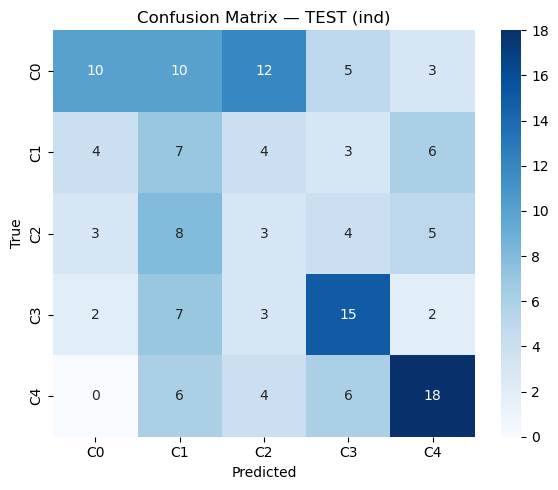


Classification Report (TEST):
              precision    recall  f1-score   support

           0     0.5263    0.2500    0.3390        40
           1     0.1842    0.2917    0.2258        24
           2     0.1154    0.1304    0.1224        23
           3     0.4545    0.5172    0.4839        29
           4     0.5294    0.5294    0.5294        34

    accuracy                         0.3533       150
   macro avg     0.3620    0.3438    0.3401       150
weighted avg     0.3954    0.3533    0.3588       150



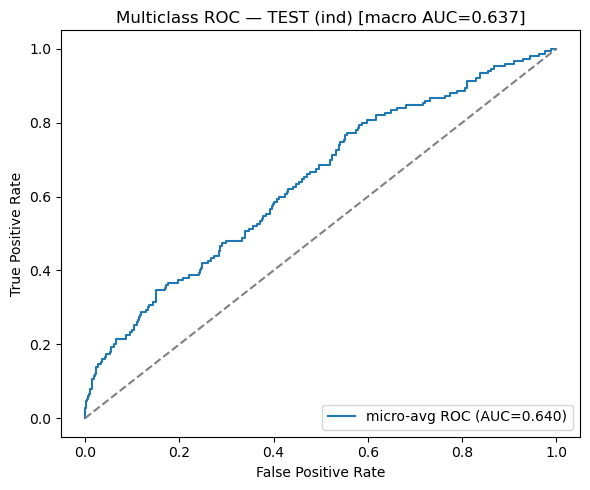

In [14]:
# Peron-Independent Split
res_ind_cls = train_from_tv_and_test_cls("ind", epochs=30, early_stop_patience=10, batch_size=16)


===== [dep] Train+Val -> Test (Text Classification) =====


C:\Users\Mansi Jadhav\AppData\Local\Temp\ipykernel_34524\3737633140.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pt_path, map_location=DEVIC

Best hyper-params (loaded): {'lr': 1.827226177606625e-05, 'weight_decay': 0.006351221010640704, 'warmup_ratio': 0.146398788362281, 'dropout': 0.25953046946896285, 'target_col': 'view_range_enc_dep', 'max_len': 256, 'seed': 42}
train+val: 350 | test: 150
internal train: 300 | internal val: 50
Epoch 01 | Train Acc 0.9400 F1 0.9402 || Val Acc 0.9200 F1 0.9185
Epoch 02 | Train Acc 0.9600 F1 0.9600 || Val Acc 0.9200 F1 0.9185
Epoch 03 | Train Acc 0.9733 F1 0.9733 || Val Acc 0.9200 F1 0.9185
Epoch 04 | Train Acc 0.9900 F1 0.9900 || Val Acc 0.9000 F1 0.8986
Epoch 05 | Train Acc 0.9833 F1 0.9833 || Val Acc 0.8800 F1 0.8785
Epoch 06 | Train Acc 0.9900 F1 0.9901 || Val Acc 0.9000 F1 0.8987
Epoch 07 | Train Acc 0.9833 F1 0.9835 || Val Acc 0.9200 F1 0.9185
Epoch 08 | Train Acc 0.9833 F1 0.9833 || Val Acc 0.9000 F1 0.9002
Epoch 09 | Train Acc 0.9900 F1 0.9901 || Val Acc 0.9000 F1 0.8997
Epoch 10 | Train Acc 0.9900 F1 0.9901 || Val Acc 0.9200 F1 0.9185
Epoch 11 | Train Acc 0.9900 F1 0.9901 || Val Ac

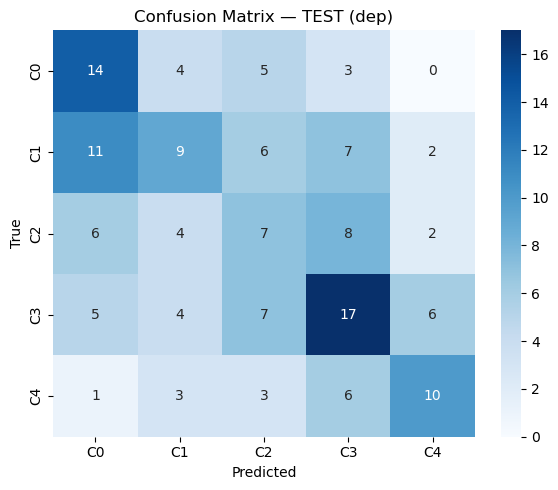


Classification Report (TEST):
              precision    recall  f1-score   support

           0     0.3784    0.5385    0.4444        26
           1     0.3750    0.2571    0.3051        35
           2     0.2500    0.2593    0.2545        27
           3     0.4146    0.4359    0.4250        39
           4     0.5000    0.4348    0.4651        23

    accuracy                         0.3800       150
   macro avg     0.3836    0.3851    0.3788       150
weighted avg     0.3826    0.3800    0.3759       150



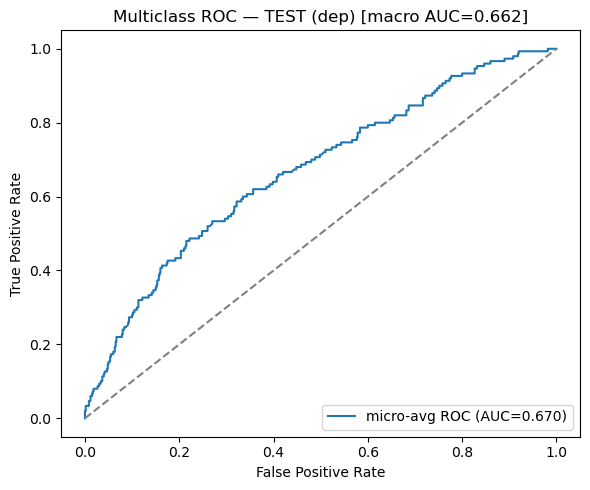

In [15]:
# Person-Dependent Split
res_dep_cls = train_from_tv_and_test_cls("dep", epochs=30, early_stop_patience=10, batch_size=16)